# Attention 
# Neural Machine Translation by jointly learning to align and translate 

**목차** 
- Rnn encoder, decoder 
- Encoder 
- Decoder 
- Attention model 
- Attention Visualize 

#  1. Background
## 1) Neural machine translation

$$( arg max ) p(y | x) $$ 

확률 관점에서 translation은 target sentence 'y' 를 위 식을 통해서 찾습니다.

Neural machine translation에서는 병렬 행렬 말뭉치를 사용해서 조건부확률을 극대화한다고 합니다.  
또한, neural machine translation components 로 두 개가 준비되어 있는데 하나는 input sentence 를 encode, 나머지 하나는 decode는 역할을 맡고 있습니다. 

## 2) Rnn Encoder - Decoder 

Align 과 translate을 동시에 진행합니다. 

$$ X = {x_1, x_2, x_3, ...x_Tx} -> vector C $$ 
<br>
$$ ht = f (x_t, h_t−1) $$

$$c = q ({h_1, · · · , h_Tx
})$$

그리고 $h_t $ 수식은 time t 때의 hidden state이며, C는 hidden states로부터 생성됩니다. 

$$
p(y) = \prod_{t=1}
^{t}Y
p(y_t | {y_1, · · · , y_t−1} , c)$$

Decoder는 다음 단어인 $y_t'$ 를 C vector와 전체 말뭉치를 이용하여 예측하는 경우도 가끔 있습니다. 다른 말로 설명한다면 위에 식처럼 표현할 수 있습니다.

RNN에서 각각의 조건부확률은 
$
p(y_t | {y_1, · · · , y_t−1} , c) = g(y_t−1, s_t, c) $로 표현됩니다.
<br>   


# 2. Neural Machine Translation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.ticker as ticker
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')
DEVICE=None

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='C:/Users/user/AppData/Local/Microsoft/Windows/Fonts/NanumSquare.ttf').get_name()
rc('font', family=font_name)

In [3]:
flatten = lambda d: [t for s in d for t in s]

def build_vocab(data, start_tkn=False):
    """build vocabulary"""
    if start_tkn:
        vocab = {'<unk>': 0, '<pad>': 1, '<s>': 2, '</s>': 3}
    else:
        vocab = {'<unk>': 0, '<pad>': 1}
    
    words = set(flatten(data))
    for t in words:
        if vocab.get(t) is None:
            vocab[t] = len(vocab) 
    return vocab

def add_pad(data, start_tkn=False):
    """add padding of sentences in batch to match lenghts"""
    if start_tkn:
        data = [['<s>'] + sent + ['</s>'] for sent in data]
    max_len = max([len(sent) for sent in data])
    data = [sent + ['<pad>']*(max_len-len(sent)) if len(sent) < max_len else sent \
            for sent in data ]
    return data

def numericalize(data, vocab):
    """numericalize and turn them into tensor"""
    f = lambda x: [vocab.get(t) if vocab.get(t) is not None else vocab.get('<unk>') for t in x]
    data = list(map(f, data))
    return data

def preprocess(data, vocab, start_tkn=False):
    data = add_pad(data, start_tkn=start_tkn)
    data = numericalize(data, vocab)
    return torch.LongTensor(data)  

def build_batch(src, trg, src_vocab, trg_vocab, is_sort=False):
    if is_sort:
        sorted_data = sorted(list(zip(src, trg)), key=lambda x: len(x[0]), reverse=True)
        src, trg = list(zip(*sorted_data))
    src = preprocess(src, src_vocab, start_tkn=False)
    trg = preprocess(trg, trg_vocab, start_tkn=True)
    if is_sort:
        return (src, src.ne(src_vocab.get('<pad>')).sum(1)), trg
    return src, trg

In [4]:
dataset = """Nice to meet you > 만나서 반가워요 \n I am very happy to meet you > 만나서 참 반가워요""".splitlines()
dataset = [s.strip().split('>') for s in dataset]
src, trg = [[sent.split() for sent in x] for x in zip(*dataset)]
src_vocab = build_vocab(src)
trg_vocab = build_vocab(trg, start_tkn=True)
(inputs, lengths), targets = build_batch(src, trg, src_vocab, trg_vocab, is_sort=True)
# 향후에 필요함
trg_itos = sorted([(v, k) for k, v in trg_vocab.items()], key=lambda x: x[0])
trg_itos = [x[1] for x in trg_itos]

In [5]:
inputs

tensor([[7, 4, 2, 3, 6, 9, 5],
        [8, 6, 9, 5, 1, 1, 1]])

In [6]:
lengths

tensor([7, 4])

In [7]:
targets

tensor([[2, 6, 5, 4, 3],
        [2, 6, 4, 3, 1]])

## Hyperparameters for Encoder

In [8]:
EMBED = 20  # embedding_size
HIDDEN = 60  # hidden_size
ENC_N_LAYER = 3  # encoder number of layers
L_NORM = True  # whether to use layernorm

## Model Structure

![](modelstructure.png)

# Proposed Encoder

  보통 Rnn을 사용한다면, 이전에 언급했던 방식처럼 $x_1$ 부터 $x_Tx$ 순서로 읽습니다.하지만, 이와 다르게 뒤에 따라오는 단어들까지 summarize 시키는 것이 제시된 모델의 encoder입니다.  
  그리고 논문에서는 BiRNN을 사용했다는 언급이 있었습니다.   

      BiRNN = bidrectional RNN 
  $$ (
\vec h_1, · · · ,
\vec h_Tx
) $$   
<br>
그리고 forward hidden states 와 다르게 벡터의 방향이 반대로 구성된 sequence 를 갖고 있습니다.   
<br>
 $$ (
\vec h_Tx, · · · ,
\vec h_1
) $$ 

## Detailed Description of the model 
## 1. Forward 
$$ s_i = f(s_i−1, y_i−1, c_i) = (1 − z_i) ◦ s_i−1 + z_i ◦ s˜_i $$
<br>

$$ s˜i = tanh (W e(y_i−1) + U [r_i ◦ s_i−1] )$$
<br>
$$ z_i= σ (W_re(y_i−1) + U_rs_i−1) $$
<br>
$$ r_i = σ (W_re(y_i−1) + U_rs_i−1) $$
<br>
위 수식들을 토대로 BiRNN은  
$$ \vec {h _i} =
(
(1 −
\vec{z_i}) ◦
\vec{h_{i-1}} +
\vec{z_i} ◦
\vec{h_i}, {i > 0}$$ 

$$ \vec {h _i} = 0, {i = 0}$$ 
을 따릅니다.

이때 2가지 전제조건도 필요합니다.
$$\ E ∈ R^
{m×K_x}$$

$$ \vec{W} ,
\vec{W_z},
\vec{W_r} ∈ R^
{n×m},
\vec{U} ,
\vec{U_z},
\vec{U_r} ∈ R
^{n×n} $$

첫번째 조건은 워드 임베딩 행렬을 나타내고 밑에 수식은 가중치 행렬들을 나타내고 있습니다.  

## 2. Backward 

forward 방식과 매우 비슷함
<br>

워드 임베딩 행렬을 forward와 같이 공유한다는 점이 BiRNN 의 특징

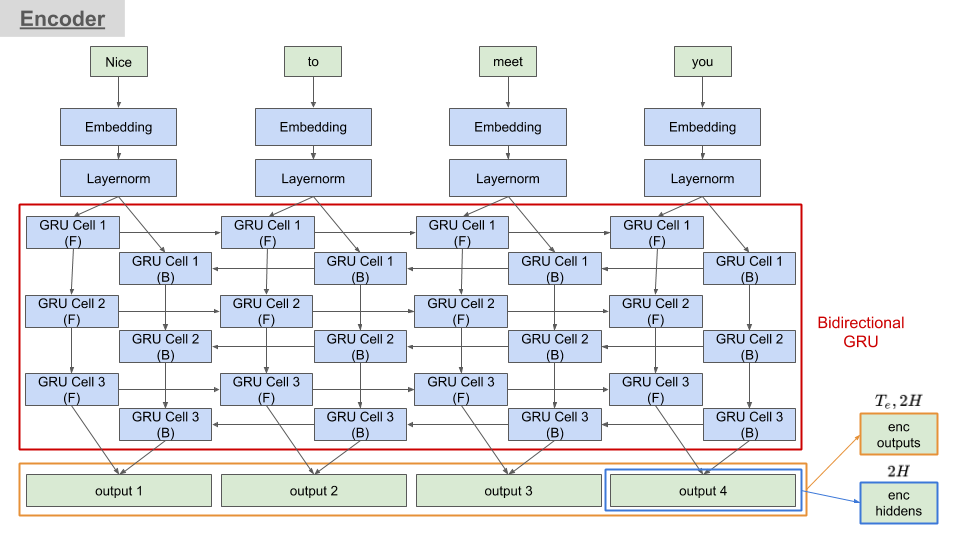


* pack_padded_sequence 

torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)

NLP에서 batch마다 고정된 문장의 길이를 만들어주기 위해서 <pad> 토큰을 넣어야합니다. 그런데 불필요한 계산을 줄이기 위해 병렬처리를 해줍니다. 
pack_padded_sequence 를 통해 batch_size를 효율적으로 지정해줍니다. 

* pad_packed_sequence

    torch.nn.utils.rnn.pad_packed_sequence(sequence, batch_first=False, padding_value=0.0, total_length=None)
    Example->
     >>> from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
     >>> seq = torch.tensor([[1,2,0], [3,0,0], [4,5,6]])
     >>> lens = [2, 1, 3]
     >>> packed = pack_padded_sequence(seq, lens, batch_first=True, enforce_sorted=False)
     >>> packed
     PackedSequence(data=tensor([4, 1, 3, 5, 2, 6]), batch_sizes=tensor([3, 2, 1]),
               sorted_indices=tensor([2, 0, 1]), unsorted_indices=tensor([1, 2, 0]))
    >>> seq_unpacked, lens_unpacked = pad_packed_sequence(packed, batch_first=True)
    >>> seq_unpacked
    tensor([[1, 2, 0],
        [3, 0, 0],
        [4, 5, 6]])
    >>> lens_unpacked
    tensor([2, 1, 3])

batch를 반환시켜주는데 B의 elements들은 pack_padded_sequence를 거쳤을때랑 마찬가지로 정렬됩니다.

## Encoder Model

In [9]:
class Encoder(nn.Module):
    """Encoder"""
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers, layernorm=False, bidirec=False):
        super(Encoder, self).__init__()        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_direction = 2 if bidirec else 1
        self.layernorm = layernorm
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, n_layers, bidirectional=bidirec, 
                          batch_first=True)
        if layernorm:
            self.l_norm = nn.LayerNorm(embed_size)
        
    def forward(self, inputs, lengths):
        """
        Inputs:
        - inputs: B, T_e
        - lengths: B, (list)
        Outputs:
        - outputs: B, T_e, n_directions*H
        - hiddens: 1, B, n_directions*H
        """
        assert isinstance(lengths, list), "lengths must be a list type"
        # B: batch_size, T_e: enc_length, M: embed_size, H: hidden_size
        inputs = self.embedding(inputs) # (B, T_e) > (B, T_e, m)
        if self.layernorm:
            inputs = self.l_norm(inputs)
        
        packed_inputs = pack_padded_sequence(inputs, lengths, batch_first=True)
        # packed_inputs: (B*T_e, M) + batches: (T_e)
        packed_outputs, hiddens = self.gru(packed_inputs)
        # packed_outputs: (B*T_e, n_directions*H) + batches: (T_e)
        # hiddens: (n_layers*n_directions, B, H)
        outputs, outputs_lengths = pad_packed_sequence(packed_outputs, batch_first=True)
        # output: (B, T_e, n_directions*H) + lengths (B)
        hiddens = torch.cat([h for h in hiddens[-self.n_direction:]], 1).unsqueeze(0)
        # hiddens: (1, B, n_directions*H)
        return outputs, hiddens

In [10]:
encoder = Encoder(len(src_vocab), EMBED, HIDDEN, ENC_N_LAYER, L_NORM, bidirec=True)
enc_output, enc_hidden = encoder(inputs, lengths.tolist())
enc_output.size(), enc_hidden.size()

(torch.Size([2, 7, 120]), torch.Size([1, 2, 120]))

* BMM

If input is a $(b×n×m)$ tensor, mat2 is a $(b \times m \times p)$ tensor, out will be a $(b \times n \times p)$ tensor.
<br>
<br>
    $torch.bmm(input, mat2, *, deterministic=False, out=None) → Tensor$

    
    >>> input = torch.randn(10, 3, 4)
    >>> mat2 = torch.randn(10, 4, 5)
    >>> res = torch.bmm(input, mat2)
    >>> res.size()
    torch.Size([10, 3, 5]

## Attention

![](attention.png)

In [11]:
class Attention(nn.Module):
    """Attention"""
    def __init__(self, hidden_size, method='general', device='cpu'):
        super(Attention, self).__init__()
        """
        * hidden_size: decoder hidden_size(H_d=encoder_gru_direction*H)
        methods:
        - 'dot': dot product between hidden and encoder_outputs
        - 'general': encoder_outputs through a linear layer 
        - 'concat': concat (hidden, encoder_outputs) ***NOT YET***
        - 'paper': concat + tanh ***NOT YET***
        """
        self.method = method
        self.device = device
        self.hidden_size = hidden_size 
        if self.method == 'general':
            self.linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, hiddens, enc_outputs, enc_lengths=None, return_weight=False):
        """
        Inputs:
        - hiddens(previous_hiddens): B, 1, H_d
        - enc_outputs(enc_outputs): B, T_e, H_d
        - enc_lengths: real lengths of encoder outputs
        - return_weight = return weights(alphas)
        Outputs:
        - contexts: B, 1, H_d
        - attns: B, 1, T_e
        """
        hid, out = hiddens, enc_outputs
        # Batch(B), Seq_length(T)
        B, T_d, H = hid.size()
        B, T_e, H = out.size()
        
        score = self.get_score(hid, out)
        # score: B, 1, T_e
        if enc_lengths is not None:
            mask = self.get_mask(B, T_d, T_e, enc_lengths)  # masks: B, 1, T_e
            score = score.masked_fill(mask, float('-inf'))
        
        attns = torch.softmax(score, dim=2)  # attns: B, 1, T_e
        contexts = attns.bmm(out)
        if return_weight:
            return contexts, attns
        return contexts
            
    def get_score(self, hid, out):
        """
        Inputs:
        - hid(previous_hiddens): B, 1, H_d 
        - out(enc_outputs): B, T_e, H_d
        Outputs:
        - score: B, 1, T_e
        """
        if self.method == 'dot':
            # bmm: (B, 1, H_d) * (B, H, T_e) = (B, 1, T_e)
            score = hid.bmm(out.transpose(1, 2))
            return score
        
        elif self.method == 'general':
            # linear: (B, T_e, H_d) > (B, T_e, H_d)
            # bmm: (B, 1, H_d) * (B, H_d, T_e) = (B, 1, T_e)
            score = self.linear(out)
            score = hid.bmm(score.transpose(1, 2))
            return score

    def get_mask(self, B, T_d, T_e, lengths):
        assert isinstance(lengths, list), "lengths must be list type"
        mask = torch.zeros(B, T_d, T_e, dtype=torch.uint8).to(self.device)
        for i, x in enumerate(lengths):
            if x < T_e:
                mask[i, :, x:].fill_(1)
        return mask

In [12]:
attention = Attention(encoder.n_direction*HIDDEN, method='general', device=DEVICE).to(DEVICE)
contexts, attns = attention(enc_hidden.transpose(0, 1), enc_output, lengths.tolist(), return_weight=True)
contexts.size(), attns.size()

(torch.Size([2, 1, 120]), torch.Size([2, 1, 7]))

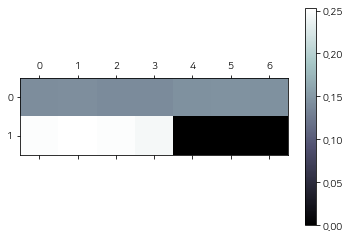

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(attns.detach().squeeze(1).numpy(), cmap='bone')
fig.colorbar(cax)
plt.show()

## Decoder model

![](decoder.png)

## Decoder

#### 계산 과정

$${ e }_{ ij }=a\left( { s }_{ i-1 },{ h }_{ j } \right)$$

* ${ e }_{ ij }$: i번째 단어 예측시, 직전 스텝의 hidden state 벡터 ${ s }_{ i-1 }$와 인코더 j번째 열벡터 ${ h }_{ j }$와의 유사도
* $a$: alignment model, feedforward neural network

$$ \alpha _{ ij }=\frac { exp\left( { e }_{ ij } \right)  }{ \sum _{ k=1 }^{ { T }_{ x } }{ exp\left( { e }_{ ik } \right)  }  }$$

* ${ e }_{ ij }$에 softmax 함수를 적용하여 확률값으로 변환
* ${ T }_{ x }$: 인코더 입력 단어 수

$${ { c }_{ i } } =\sum _{ j=1 }^{ { T }_{ x } }{ { \alpha  }_{ ij }{ h }_{ j } } =F  { { \alpha  }_{ i } }$$

* ${ c }_{ i }$: i번째 단어 예측시 쓰이는 context vector
* encoder의 모든 hidden state의 weighted sum
* encoder의 모든 hidden state는 모든 input에 대한 정보 담고 있음

#### 예시

![](example.png)

* 디코더가 두 번째 단어 'like' 예측
* attention vector 두 번째 요소값 가장 높음
* 첫 번째 hidden state 벡터 $s_1$과 가장 유사한 인코더의 열벡터 $h_2$로 판단
* context vector $c_2$는 출력벡터들로 구성된 행렬 F에 $a_2$를 내적

## Decoder

In [14]:
dec_embedding = nn.Embedding(len(trg_vocab), EMBED)     # embedding
sos = torch.LongTensor([2]*inputs.size(0)).unsqueeze(1) 
dec_input = dec_embedding(sos)
dec_input.size()

torch.Size([2, 1, 20])

## Hyperparameters for Decoder

In [15]:
DEC_N_LAYER = 1    # number of layer in Decoder
DROP_RATE = 0.2    # dropout after embedding
METHOD = 'general' # Attentioin method
TF = True          # teacher forcing
RETURN_W = True

Teacher Forcing
* 이전의 값에 오류가 있다면 그 오류에 의존하여 계속 잘못된 디코딩이 연쇄적으로 일어남
* 학습할 때 예측값이 input이 아닌 실제값을 input으로 적용하여 학습하는 방법
* 즉, 이전값은 correct answer로부터 가져오도록 하는 기법

In [16]:
class Decoder(nn.Module):
    # 정의
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers=1, sos_idx=2, drop_rate=0.0, layernorm=False, method='general', teacher_force=False, device='cpu', return_w=False):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.sos_idx = sos_idx
        self.return_w = return_w
        self.teacher_force = teacher_force
        self.layernorm = layernorm
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(drop_rate)
        self.attention = Attention(hidden_size, method=method, device=device)
        self.gru = nn.GRU(embed_size+hidden_size, hidden_size, n_layers, bidirectional=False, 
                          batch_first=True)
        self.linear = nn.Linear(2*hidden_size, vocab_size)
        if layernorm:
            self.l_norm = nn.LayerNorm(embed_size)
    
    def start_token(self, batch_size):
        sos = torch.LongTensor([self.sos_idx]*batch_size).unsqueeze(1).to(self.device)
        return sos
    
    def init_hiddens(self, batch_size):
        return torch.zeros(batch_size, self.n_layers, self.hidden_size).to(self.device)
    
    def forward(self, hiddens, enc_output, enc_lengths=None, max_len=None, targets=None, 
                is_eval=False, is_test=False, stop_idx=3):
        """
        * B: bacth size
        * H_d: decoder hidden_size
        * M_d: decoder embedding_size
        Inputs:
        - hiddens: last encoder hidden at time 0
        - enc_output: encoder output
        - enc_lengths: encoder lengths 
        - max_len: max lenghts of target 
        Outputs:
        - scores: results of all predictions 
        - attn_weights: attention weight for all batches
        """
        if is_test:
            is_eval=True
        inputs = self.start_token(hiddens.size(1))  # (B, 1)
        inputs = self.embedding(inputs) # (B, 1, M_d)
        if self.layernorm:
            inputs = self.l_norm(inputs)
        inputs = self.dropout(inputs)
        # layer 크기 맞추기
        if hiddens.size(0) != self.n_layers:
            hiddens = hiddens.repeat(self.n_layers, 1, 1)
        # 전체 타겟 문장에 대해 실행
        scores = []  
        attn_weights = []
        for i in range(1, max_len):
            # contexts = (i-1번째 hidden state, i번째 encoder output) 유사도 측정 후 가중합 계산
            contexts = self.attention(hiddens[-1:, :].transpose(0, 1), enc_output, enc_lengths, 
                                      return_weight=self.return_w)
    
            if self.return_w:
                attns = contexts[1]      
                contexts = contexts[0]   
                attn_weights.append(attns) 
            
            # gru_inputs = (i-1번째 임베딩 토큰, i번째 context) concat
            gru_inputs = torch.cat((inputs, contexts), 2)
            
            # hidden sate 계산
            # (gru_input, i-1번째 hidden state)
            _, hiddens = self.gru(gru_inputs, hiddens)  # (B, 1, M_d+H_d) > (n_layers, B, H_d)         
            
            # score 계산
            # (i-1번째 hidden state, i번째 context) linear
            score = self.linear(torch.cat((hiddens[-1:, :].transpose(0, 1), contexts), 2))
            scores.append(score)
    
            if (self.teacher_force and not is_eval):
                selected_targets = targets[:, i].unsqueeze(1)
            else:
                selected_targets = None
            
            inputs, stop_decode = self.decode(is_tf=self.teacher_force, 
                                              is_eval=is_eval,
                                              is_test=is_test,
                                              score=score, 
                                              targets=selected_targets, 
                                              stop_idx=stop_idx)
            if stop_decode:
                break
            
        scores = torch.cat(scores, 1).view(-1, self.vocab_size)  # (B, T_d, vocab_size) > (B*T_d, vocab_size)
        if self.return_w:
            return scores, torch.cat(attn_weights, 1)  # (B, T_d, T_e)
        return scores
    
    def decode(self, is_tf, is_eval, is_test, score, targets, stop_idx):
        # stop_decode가 True가 될 때까지 반복
        stop_decode = False
        # 테스트
        if is_test:
            preds = score.max(2)[1]
            if preds.view(-1).item() == stop_idx:
                stop_decode = True
            inputs = self.embedding(preds)
        else:
            # 훈련
            if is_tf and not is_eval:
                assert targets is not None, "target must not be None in teacher force mode"
                inputs = self.embedding(targets)
            # 검증
            else:
                preds = score.max(2)[1]
                inputs = self.embedding(preds)

        if self.layernorm:
            inputs = self.l_norm(inputs)
        inputs = self.dropout(inputs)
        return inputs, stop_decode

In [17]:
decoder = Decoder(len(trg_vocab), EMBED, encoder.n_direction*HIDDEN, n_layers=DEC_N_LAYER,
                  drop_rate=DROP_RATE, method=METHOD, layernorm=L_NORM, 
                  sos_idx=trg_vocab['<s>'], teacher_force=TF, 
                  return_w=RETURN_W, device=DEVICE)

In [18]:
output, attns = decoder(hiddens=enc_hidden, enc_output=enc_output, max_len=targets.size(1),
                targets=targets)
output.size(), attns.size()

(torch.Size([8, 7]), torch.Size([2, 4, 7]))

## Train

In [19]:
LR = 0.01
LAMBDA = 0.00001
DECLR = 5.0
STEP = 5

In [20]:
loss_function = nn.CrossEntropyLoss(ignore_index=trg_vocab['<pad>'])
enc_optimizer = optim.Adam(encoder.parameters(), 
                           lr=LR, 
                           weight_decay=LAMBDA)
dec_optimizer = optim.Adam(decoder.parameters(), 
                           lr=LR * DECLR, 
                           weight_decay=LAMBDA)

* Cross Entropy

$$Loss = -\sum_{k=1}^{K} \log\big(p(k) \big) q(k)$$

$$\begin{aligned} \dfrac{\partial Loss}{\partial z_k} = q(k)\big(p(k)-1\big) \end{aligned}$$

$$q(k)=\delta_{k,y} \begin{cases} 1 \quad \text{if } k=y \\ 0 \quad \text{else} \end{cases}$$

STEP: 0, loss: 1.8959


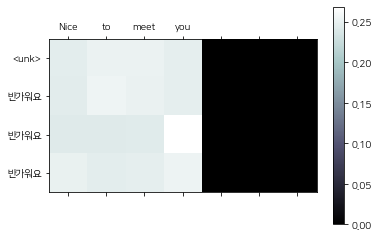

STEP: 1, loss: 1.1382


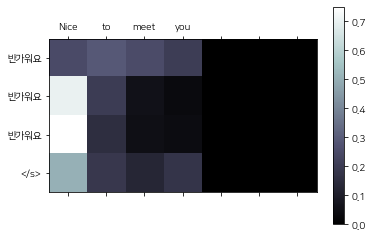

STEP: 2, loss: 1.7621


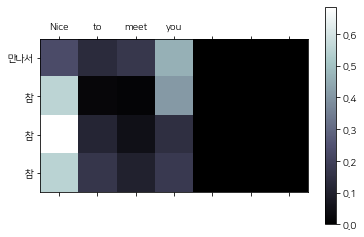

STEP: 3, loss: 1.6589


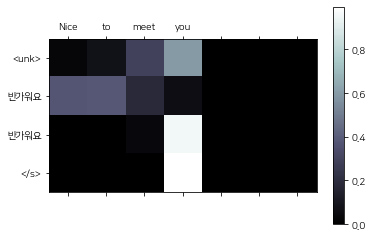

STEP: 4, loss: 0.2688


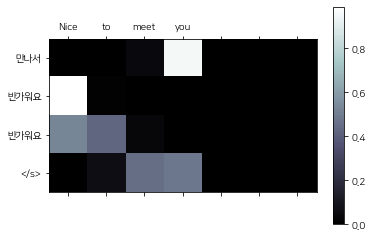

In [21]:
encoder.train()
decoder.train()
losses = []
for i in range(STEP):
    encoder.zero_grad() # 변화도 초기화
    decoder.zero_grad() # 변화도 초기화
    enc_output, enc_hidden = encoder(inputs, lengths.tolist())
    outputs, attns = decoder(enc_hidden, enc_output, lengths.tolist(), 
                     targets.size(1), targets, is_eval=False)
    
    
    loss = loss_function(outputs, targets[:, 1:].contiguous().view(-1))
    losses.append(loss.item())
    # loss 확인
    print('STEP: {}, loss: {:.4f}'.format(i, loss.item()))
    # attention 확인
    preds = outputs.max(1)[1]
    translated = list(map(lambda x: trg_itos[x], preds.tolist()))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attns[1].detach().numpy(), cmap='bone')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + src[0])
    ax.set_yticklabels([''] + translated)
    plt.show()
    
    loss.backward()
    
    enc_optimizer.step()
    dec_optimizer.step()